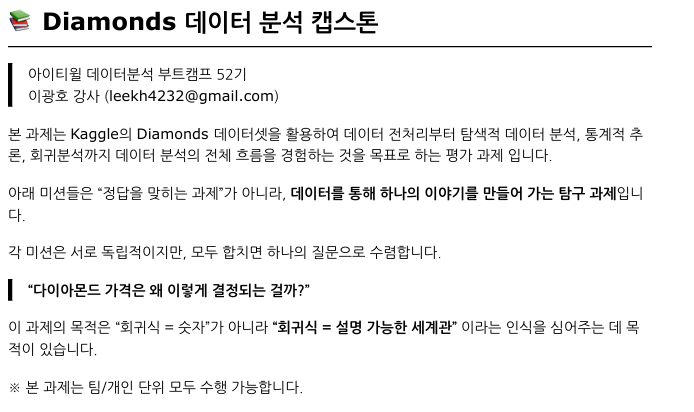

In [106]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

from itertools import combinations

import statsmodels.api as sm
import statsmodels.formula.api as ols

from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [107]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

데이터 불러오기

In [108]:
origin = load_data('diamonds')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab12_/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성을 기준으로 분석합니다. (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------------------------------------
price    price in US dollars ($326 ~ $18,823)
carat    weight of the diamond (0.2~5.01)
cut      quality of the cut (Fair, Good, Very Good, Premium, Ideal)
color    diamond colour, from J (worst) to D (best)
clarity  a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        length in mm (0~10.74)
y        width in mm (0--58.9)
z        depth in mm (0--31.8)
depth    total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    width of top of diamond relative to widest point (43--95)


===== 데이터 크기 확인 =====
데이터셋 크기 : (53940, 10)
열 개수: 10
행 개수: 53940

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries,

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0


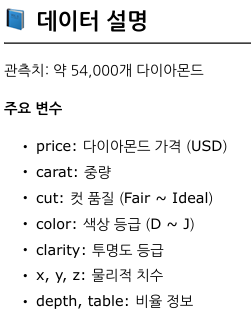

#### 미션 1. "이 데이터는 얼마나 믿을 수 있을까?"
- 신뢰도 점검
    1. 비어 있는 값
    2. 유난히 튀는 값
    3. 현실적으로 말이 되지 않는 값(도메인 지식)
> ex) 다이아몬드 크기를 나타내는 값이 0으로 되어있는지
> 만약 되어 있다면 그대로 분석에 써도 되는지?
>
> 또한, cut, color, clarity와 같은 품질 변수들이 몇 개의 범주로 구성되어 있고, 특정 범주에 데이터가 지나치게 몰려있지는 않은지?
>
>전처리 전과 후를 비교하여 어떤 기준으로 데이터를 제거하거나 수정했는지

In [109]:
# 비어있는 값 찾기
df = origin.copy()
df.isnull().sum()

price      0
carat      0
cut        0
color      0
clarity    0
x          0
y          0
z          0
depth      0
table      0
dtype: int64

In [110]:
# 유난히 튀는 값 찾기
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00


In [111]:
# category 타입으로 변환
df = df.astype({'cut':'category', 'color':'category', 'clarity':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   price    53940 non-null  int64   
 1   carat    53940 non-null  float64 
 2   cut      53940 non-null  category
 3   color    53940 non-null  category
 4   clarity  53940 non-null  category
 5   x        53940 non-null  float64 
 6   y        53940 non-null  float64 
 7   z        53940 non-null  float64 
 8   depth    53940 non-null  float64 
 9   table    53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


##### 1. 수치형 변수 통계량
1. 기술 통계 확인

In [112]:
df2 = df[['carat','depth','table','price','x','y','z']]
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80


- 대부분의 데이터가 평균이 크지만 price를 제외한 나머지 컬럼은 평균과 중앙값의 차이가 거의 없음

>carat : 평균(0.79) > 중앙값(0.7)
>
>depth : 평균 (61.7) < 중앙값 (61.8)
>
>table : 평균 (57.4) > 중앙값 (57.0)
>
>price : 평균 (3932.7) > 중앙값 (2401.0)
>
>x : 평균 (5.73) > 중앙값 (5.7)
>
>y : 평균 (5.73) > 중앙값 (5.71)
>
>z : 평균 (3.538) >= 중앙값 (3.53)

모든 항목에 이상치가 존재하므로 로그 변환 시도

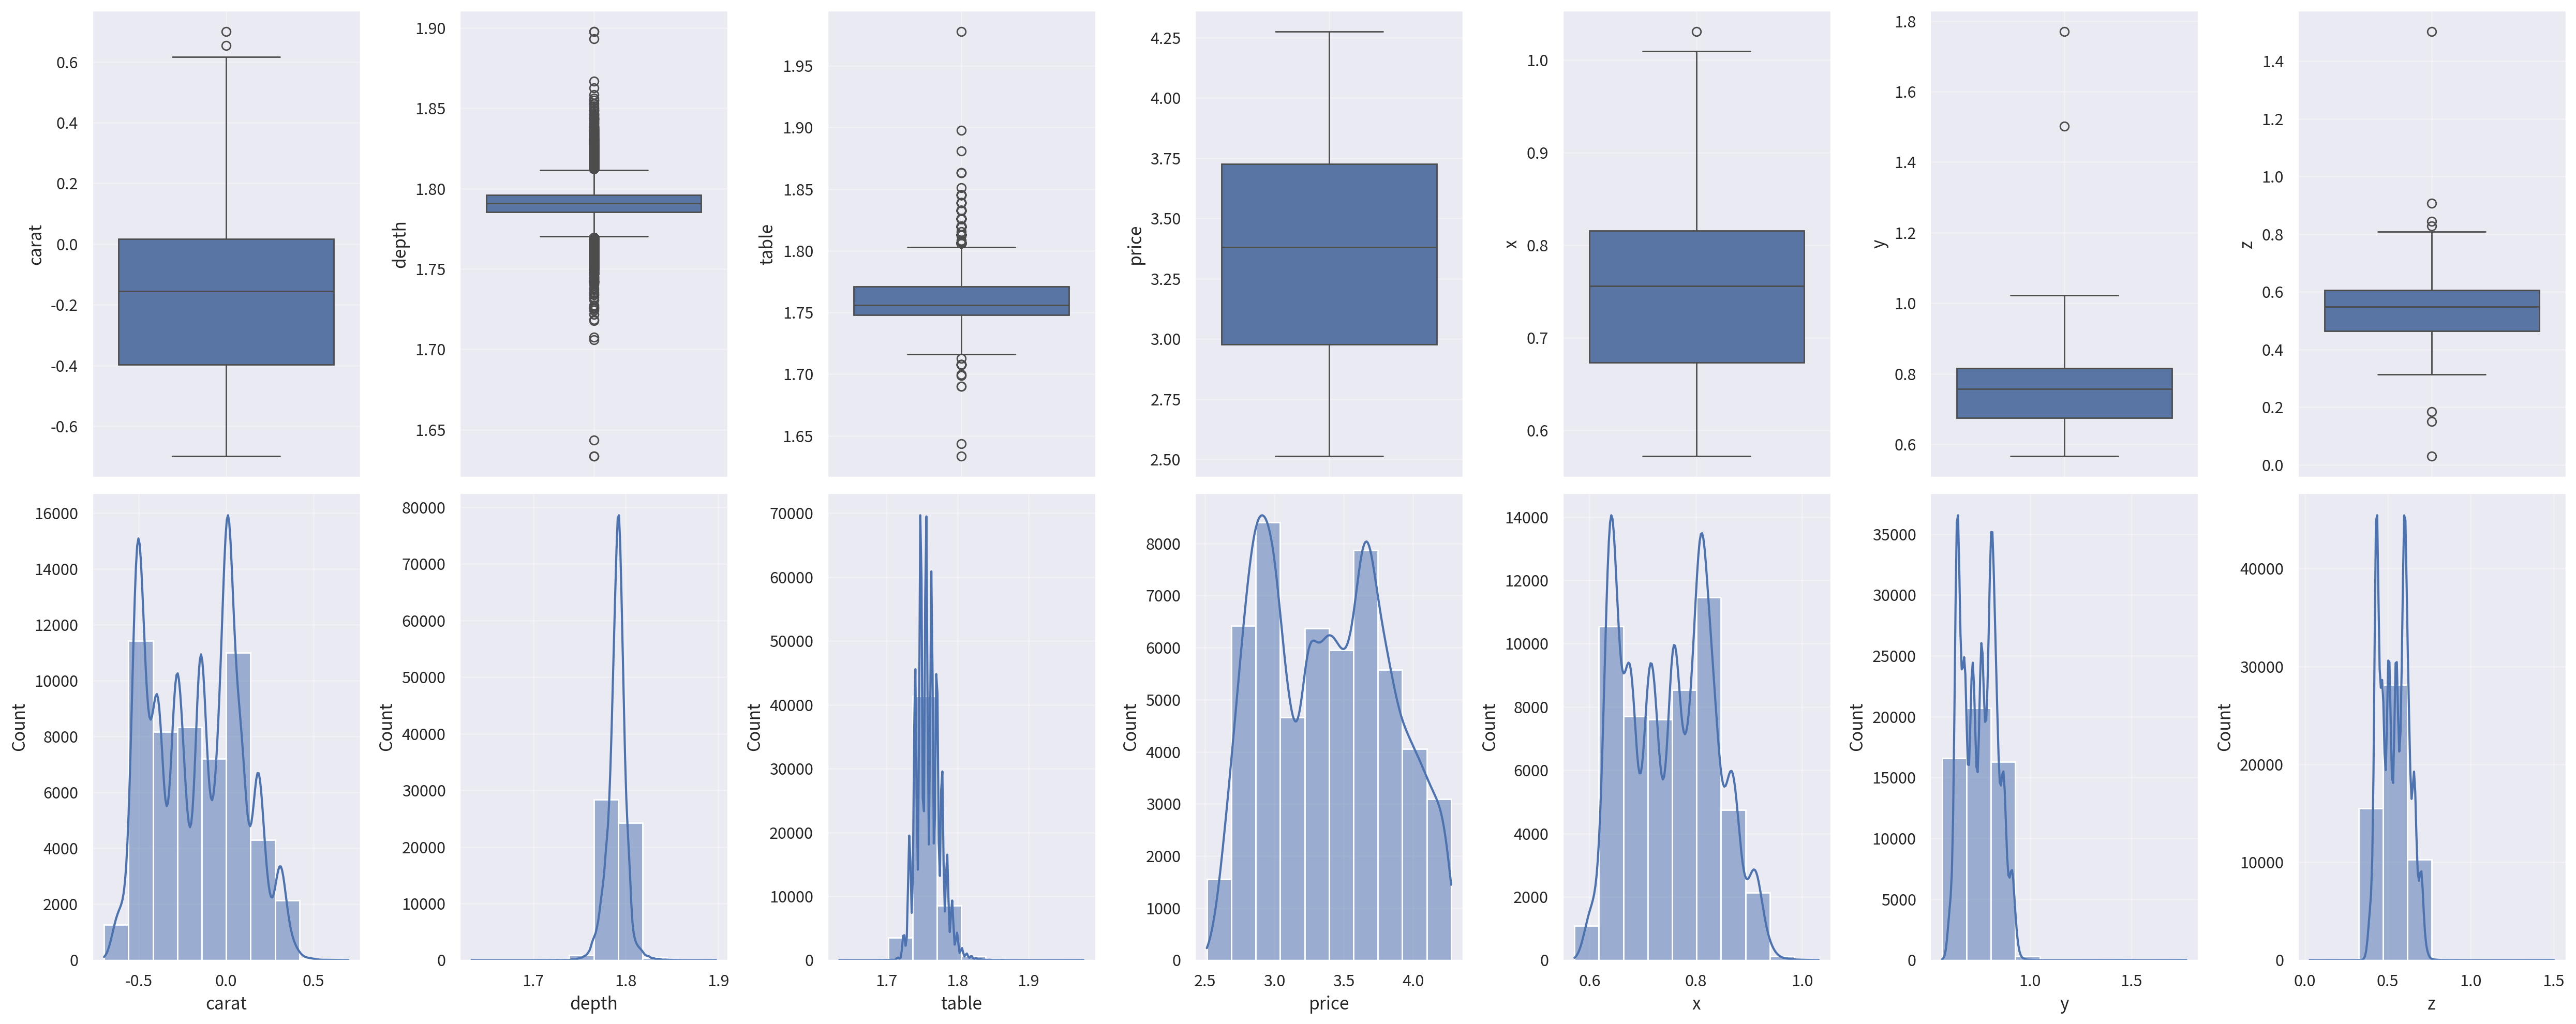

In [113]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 5000             #그래프 가로 크기
height_px = 2000             #그래프 세로 크기
rows = 2                    #도화지의 행 수
cols = 7                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i, col in enumerate(['carat','depth','table','price','x','y','z']):
    data = df2[df2[col] > 0][col]
    log_data = np.log10(data)

    sb.boxplot(log_data, orient='v', ax=ax[0][i])
    ax[0][i].grid(True, alpha=0.3)

    sb.histplot(log_data, bins=10, kde=True, ax=ax[1][i])
    ax[1][i].grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

로그변환 후 시각화를 통해 분포 확인
- 대칭성은 띄는 것 같은데.. 정규분포와 거리가 먼 것을 확인
- price를 제외한 모든 컬럼에 이상치 존재

##### 2. 범주형 변수 통계량

In [114]:
# 빈도 및 최빈값 확인
df.describe(include='category')

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


In [115]:
# 범주형 변수 null값 확인
df[['cut','color','clarity']].isnull().sum()

cut        0
color      0
clarity    0
dtype: int64

##### 3. 데이터 품질 종합 평가에 대한 결과 보고
- 데이터 완성도(Completeness) - 결측값 0개: 완벽한 데이터 완성도 달성 
- 데이터 일관성(Consistency) - price(가격) 변수는 int형, 그 외의 변수는 float으로 일관성 유지 (price 변수를 일관성 유지를 위해 float으로 변환해도 되는지? 혹은 해야 하는 것?)
- 데이터 분포 특성 - 중앙값과 평균의 차이가 거의 나지 않지만 정규분포는 따르지 않음, price컬럼을 제외한 나머지 컬럼은 편차가 크지 않음 - 나머지 컬럼의 값이 조금만 변해도 price는 확 변할 수 있다는 뜻 (최대 3989 USD 까지도 변함)
- 분석 시 고려사항 - 다이아몬드간 가격 차이가 꽤 크므로 데이터를 구간별로 나누어서 분석 시도 고려 - 이상치 처리 필수 - 실제 데이터이므로 스케일링을 통한 해결이 바람직
    - 가격에 미치는 요인 고려
---
- 신뢰도 점검
    1. 비어 있는 값 - 없음
    2. 유난히 튀는 값 - 존재하지만 실제 데이터 값이므로 삭제보다는 스케일링을 통해 해결
    3. 현실적으로 말이 되지 않는 값(도메인 지식) - 0인 값은 없었음, 
    4. 전처리 전과 후 어떤 데이터를 삭제, 수정했는지 - object를 category 타입으로 변환, 삭제 데이터는 없음
    5. 대부분의 데이터는 평균과 중앙값에 몰려있음.

#### 미션 2. "가격 데이터는 어떤 모습일까?"
- price 변수를 처음 마주했을 때의 분포를 직접 그려보자. 가격이 고르게 분포되어 있는지, 아니면 특정 구간에 몰려 있는지 관찰해 보자.
- carat 변수의 분포도 함께 살펴보고, 두 변수의 공통점과 차이점을 말로 설명해 보자.
- 분포를 살펴본 뒤에는 “이 상태로 회귀분석을 해도 괜찮을까?”라는 질문을 던져보자.

In [116]:
df3 = df2[['price']]
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
price,53940.0,3932.799722,3989.439738,326.0,950.0,2401.0,5324.25,18823.0


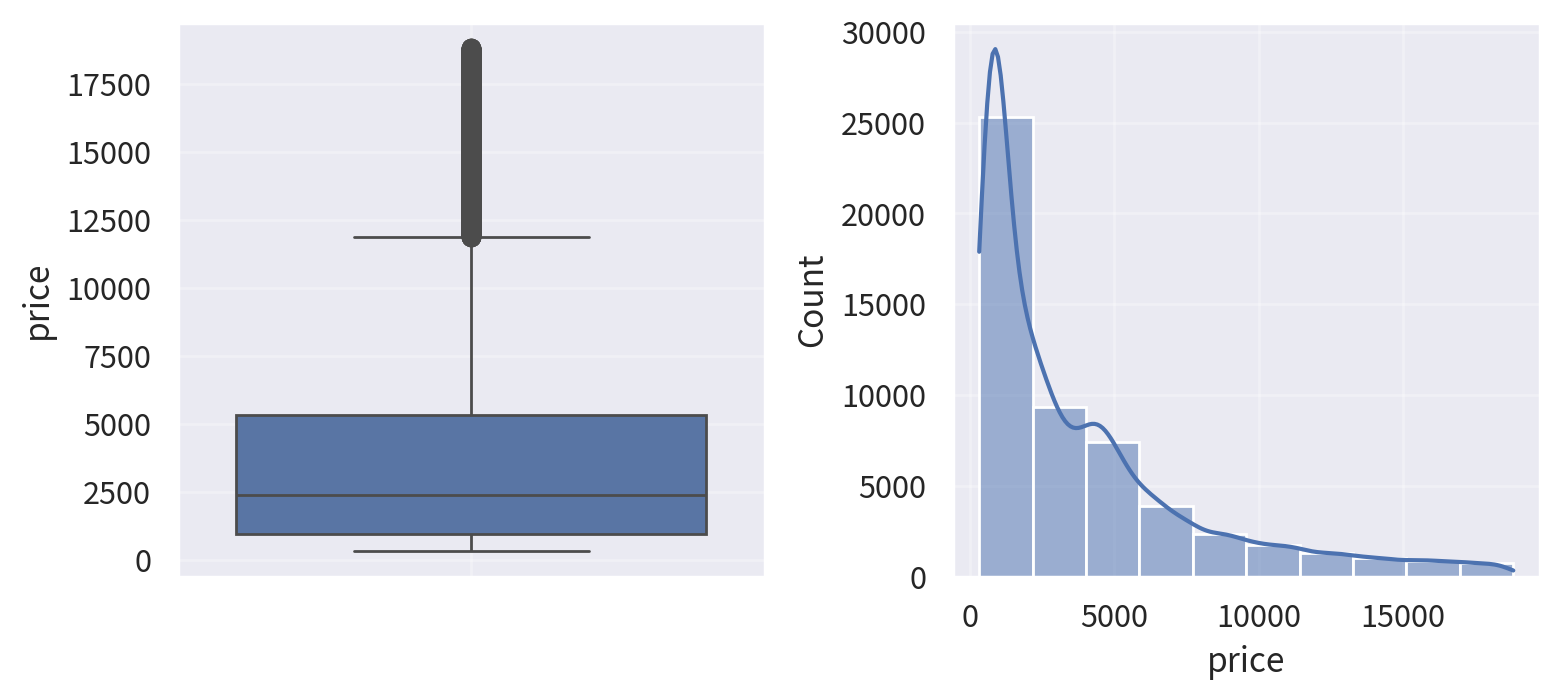

In [117]:
#price 변수 분포 그리기
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1580             #그래프 가로 크기
height_px = 720             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df3, y='price', orient='v', ax=ax[0])
sb.histplot(data=df3, x='price', bins=10, kde=True, ax=ax[1])
ax[0].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)
# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- price 변수는 평균(3932)과 중앙값(2401)구간에 몰려있는 것을 확인할 수 있음.

In [118]:
df4 = df2[['carat']]
df4.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.79794,0.474011,0.2,0.4,0.7,1.04,5.01


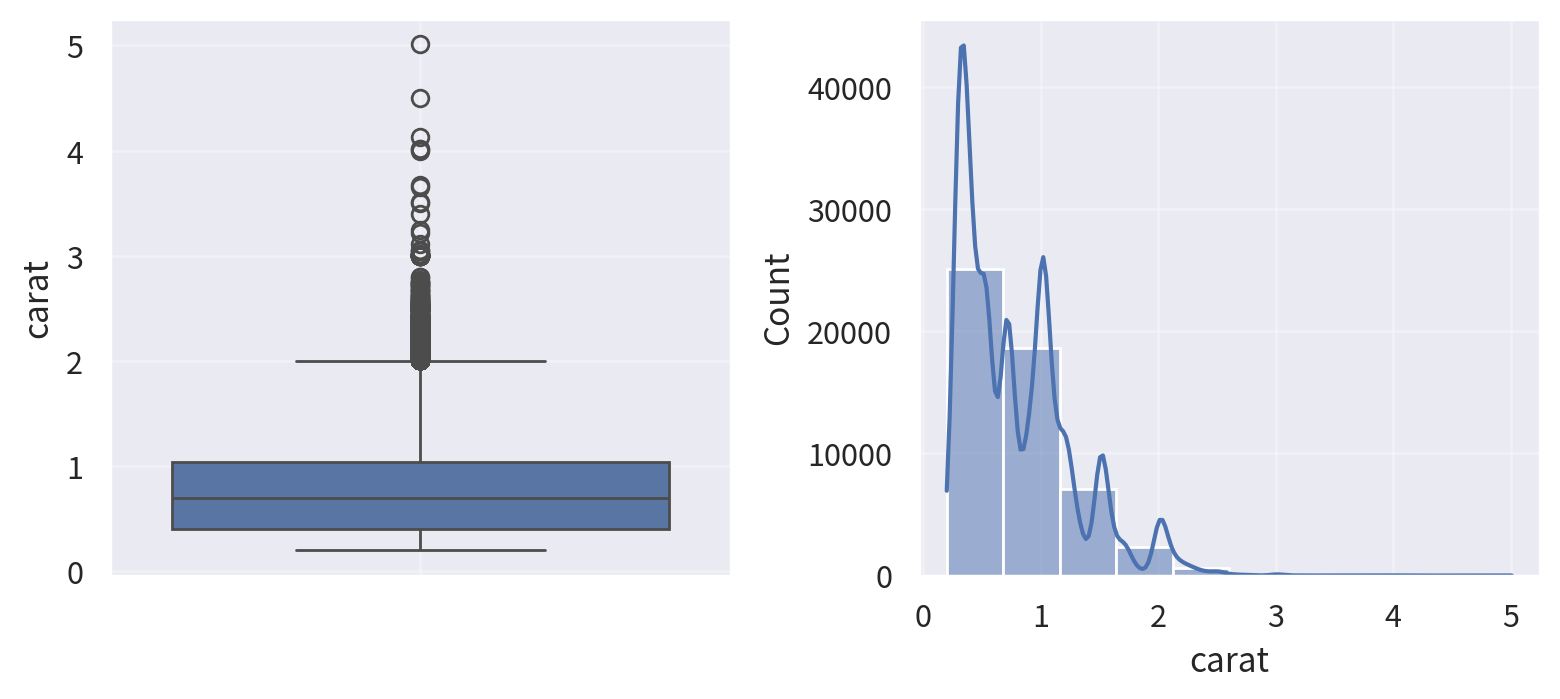

In [119]:
#price 변수 분포 그리기
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1580             #그래프 가로 크기
height_px = 720             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df4, y='carat', orient='v', ax=ax[0])
sb.histplot(data=df4, x='carat', bins=10, kde=True, ax=ax[1])
ax[0].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)
# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- carat 변수는 평균(0.79)과 중앙값(0.7)구간에 몰려있는 것을 확인할 수 있음.
- 두 변수의 공통점과 차이점
    - 공통점 
        1. 왼쪽으로 치우친 비대칭성 그래프를 띔 
        2. 이상치가 매우 많음
    - 차이점
        1. carat의 히스토그램은 여러개의 봉우리가 존재하지만 price의 히스토그램은 하나의 봉우리만 존재함.

##### “이 상태로 회귀분석을 해도 괜찮을까?”
- 종속변수의 값은 정규성(정규분포)을 지녀야 함.
- 종속, 독립 변수의 관계가 선형이어야 함 (잔차의 선형성)

> 분포가 정규분포 형태가 아니기 때문에 로그 변환과 같은 행위를 통해 대칭성을 맞춰줄 필요가 있음.



#### 미션3. "로그 변환은 왜 등장할까?"
1. price와 carat에 로그 변환을 적용해 보고, 변환 전과 후의 분포를 나란히 비교해 보자.
2. 로그 변환을 해서 무엇이 달라졌는지, 왜 많은 분석에서 로그 변환을 사용하는지 **이번 데이터 셋을 기준**으로 설명해보자.
3. 중요한 것은 **왜 썼는가**이다.

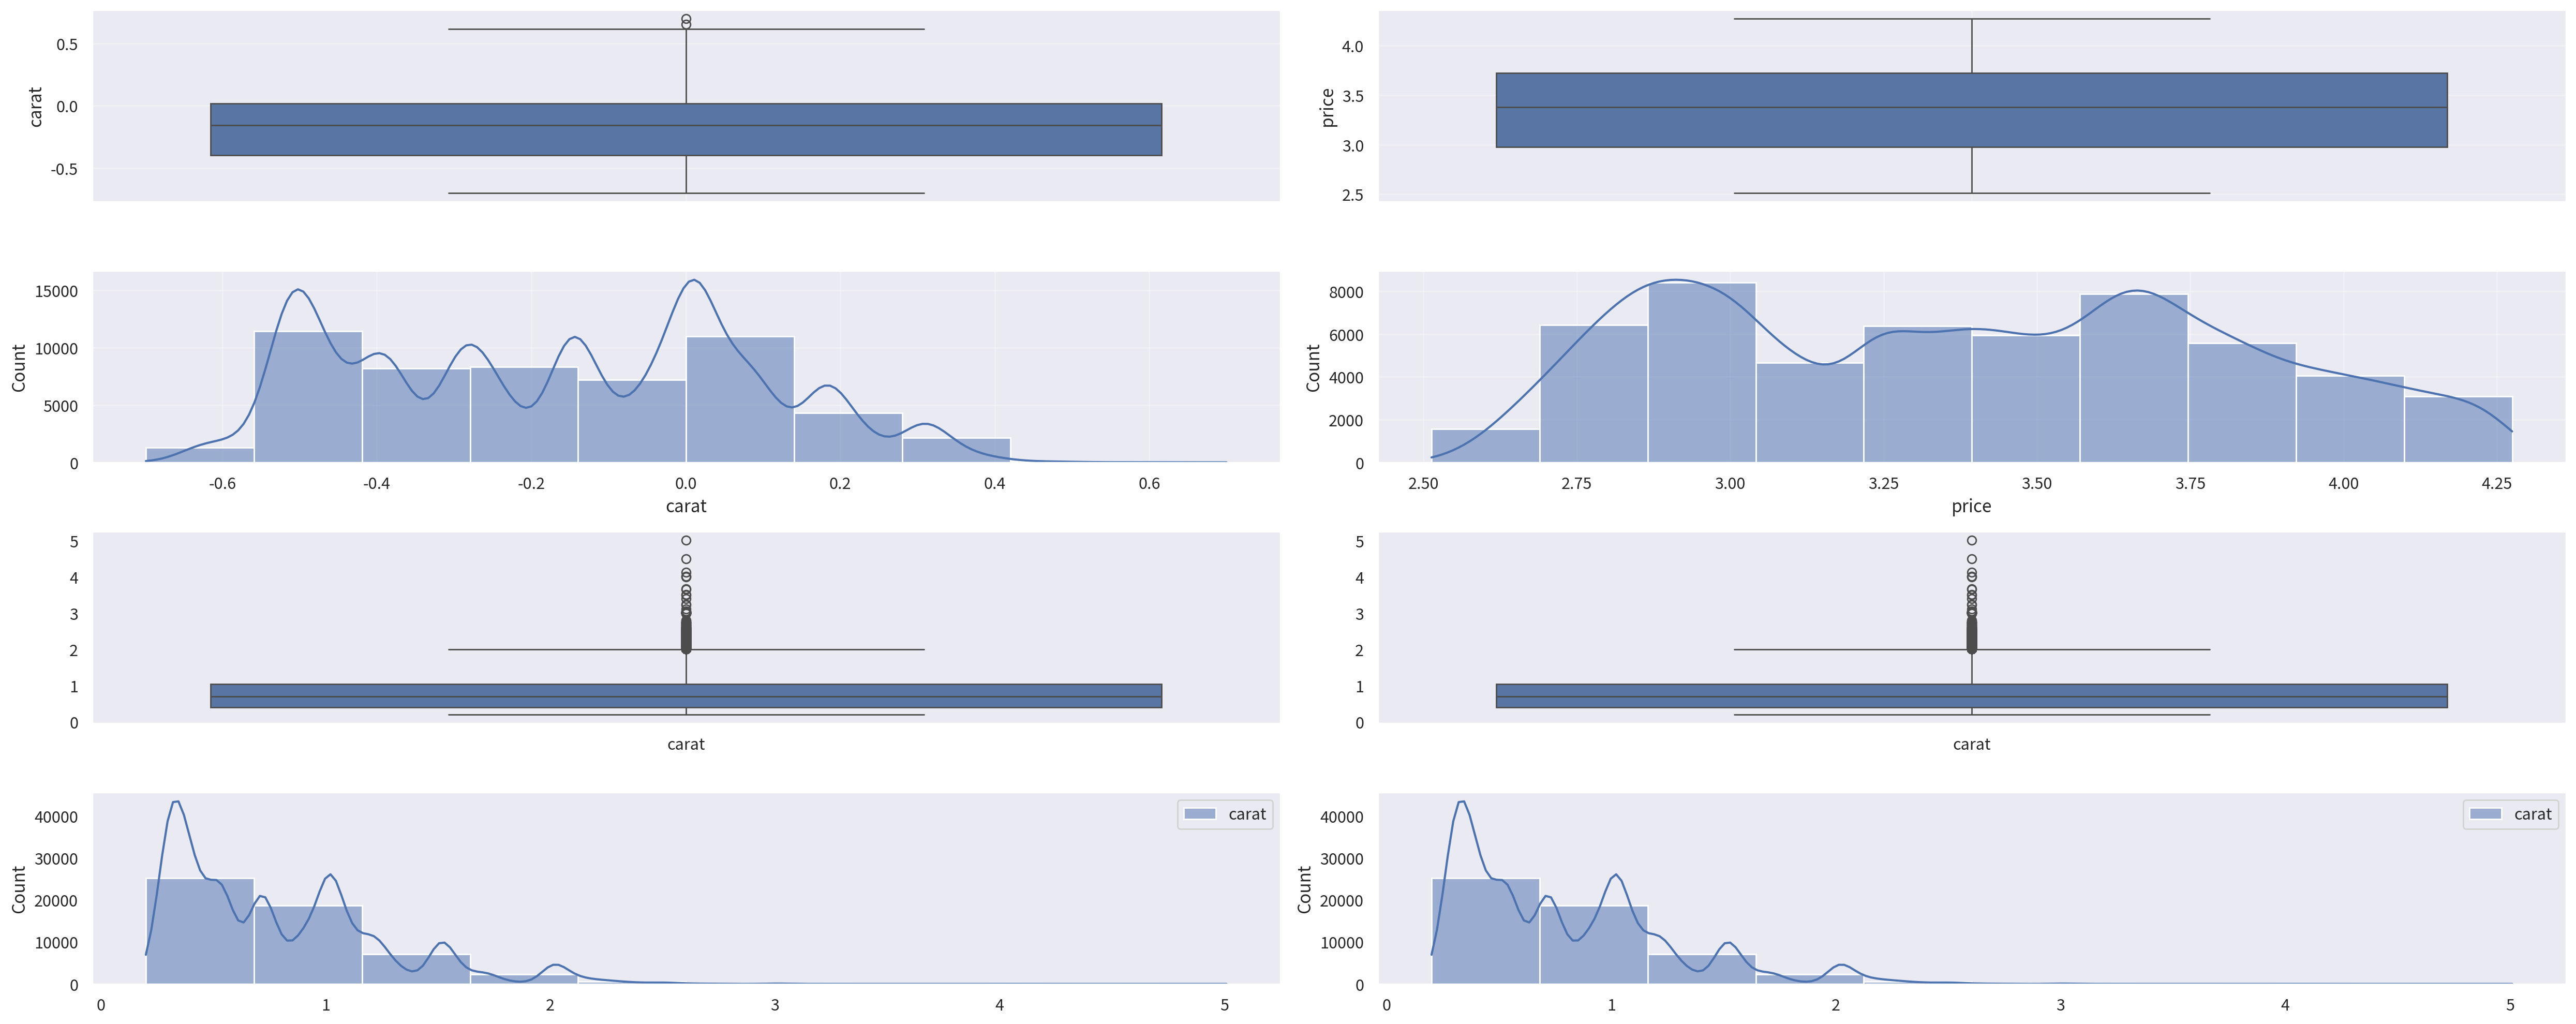

In [120]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 5000             #그래프 가로 크기
height_px = 2000             #그래프 세로 크기
rows = 4                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i, col in enumerate(['carat','price']):
    data = df2[df2[col] > 0][col]
    log_data = np.log10(data)

    sb.boxplot(log_data, orient='v', ax=ax[0][i])
    ax[0][i].grid(True, alpha=0.3)

    sb.histplot(log_data, bins=10, kde=True, ax=ax[1][i])
    ax[1][i].grid(True, alpha=0.3)

    sb.boxplot(df4, orient='v', ax=ax[2][i])
    sb.histplot(df4, bins=10, kde=True, ax=ax[3][i])


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 로그 변환을 적용하니 왼쪽으로 치우쳐 져있던 데이터 분포가 골고루 분포되게 바뀜
- 어느정도 대칭성을 띈 그래프로 변환됨
- 회귀분석을 할 수 있는가? 에 대한 해결책이자 비대칭 문제를 해결하기 위해 로그변환을 사용함. 

#### 미션 4. "품질 등급은 가격을 얼마나 설명해줄까?"
- cut, color, clarity에 따라 다이아몬드 가격 분포가 어떻게 달라지는지 시각화해 보자.
- 중앙값, 분산, 분포의 겹침 정도를 관찰하며 다음 질문에 답해보자.
    - 어떤 품질 변수는 가격 차이가 뚜렷한가?
    - 어떤 경우에는 등급이 달라도 가격이 크게 겹치는가?
- 숫자보다 패턴과 느낌을 중심으로 정리해보자.

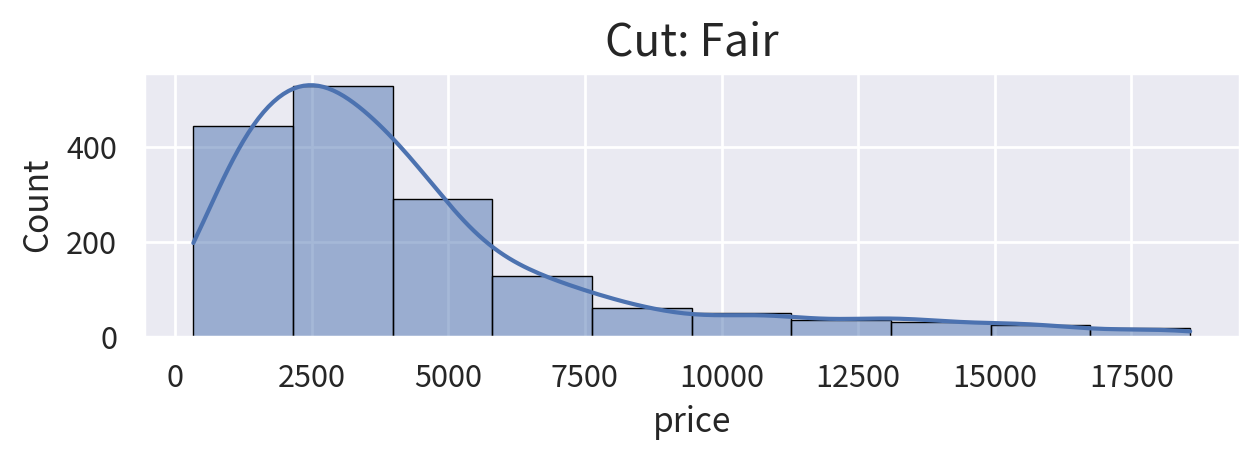

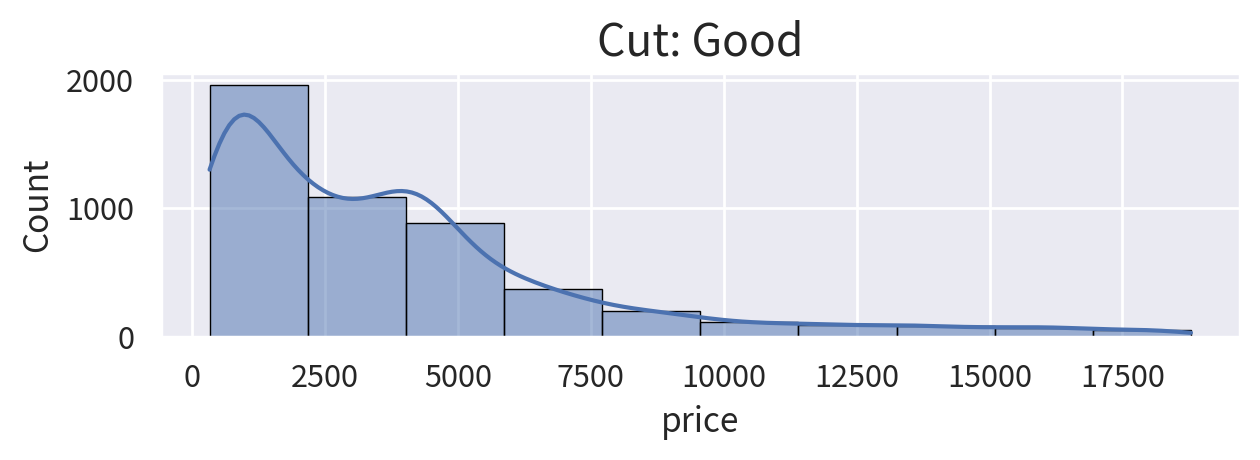

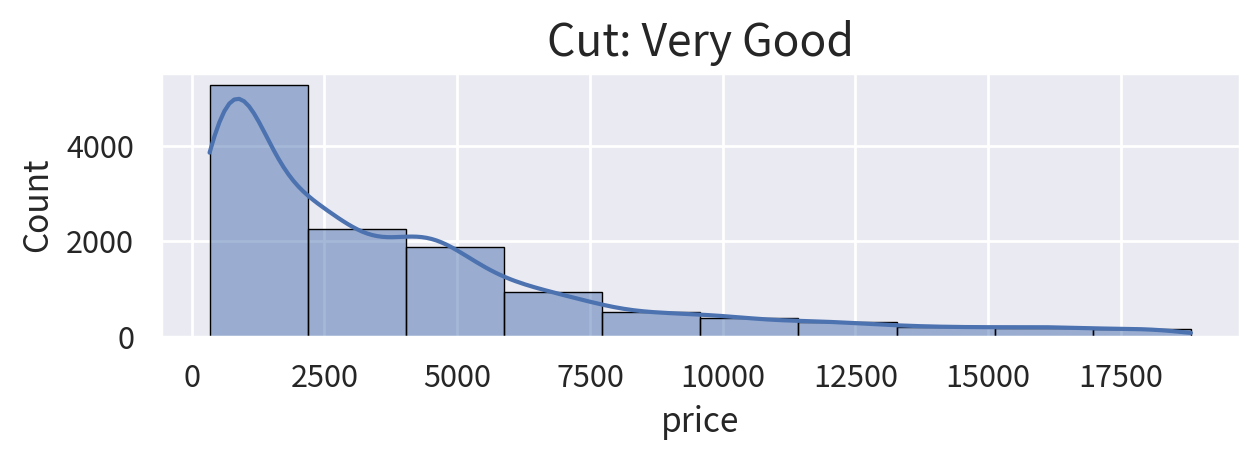

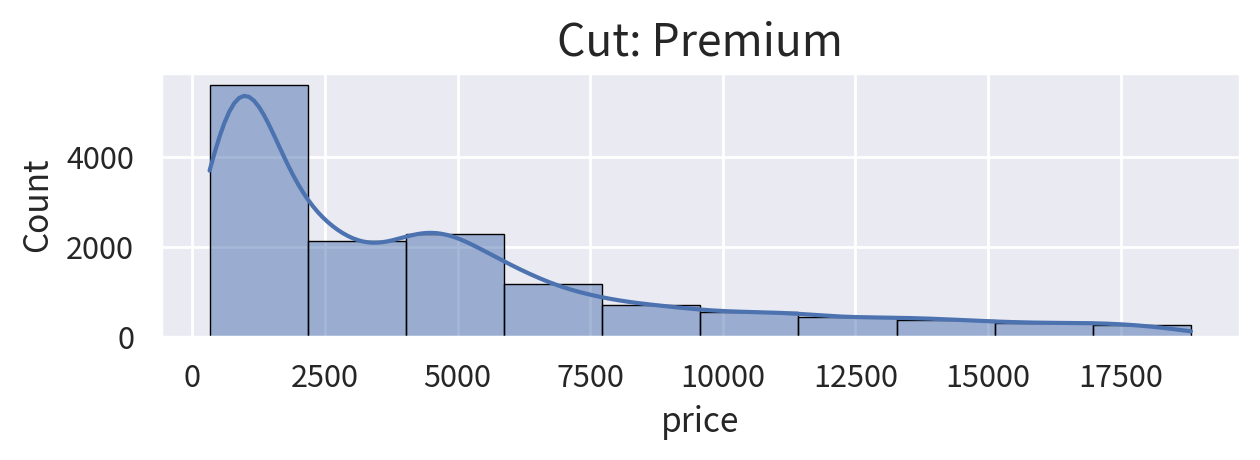

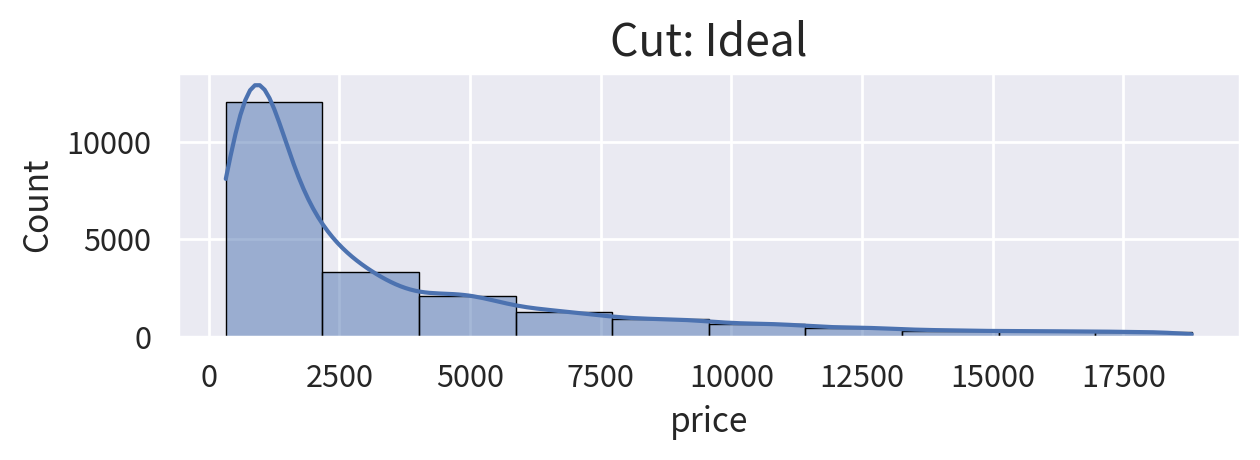

In [121]:
#cut 변수는 Fair, Good, Very Good, Premium, Ideal 순서대로
cut_values=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
# print(cut_values)

for m in cut_values:
    mdf = df.query("cut == @m")
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
    width_px = 1280             #그래프 가로 크기
    height_px = 480             #그래프 세로 크기
    rows = 1                    #도화지의 행 수
    cols = 1                    #도화지의 열 수
    figsize = (width_px / my_dpi, height_px / my_dpi)
    fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

    # 2) barplot 그리기
    sb.histplot(
        data=mdf,
        x="price",
        bins=10,
        edgecolor='black',
        linewidth=0.5,
        kde=True
    )

    # 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
    ax.set_title(f"Cut: {m}", fontsize=16)
    ax.grid(True)

    # 4) 출력
    plt.tight_layout()                      #여백 제거
    # plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
    plt.show()                              #그래프 화면 출력
    plt.close()                             #그래프 작업 종료

['D', 'E', 'F', 'G', 'H', 'I', 'J']


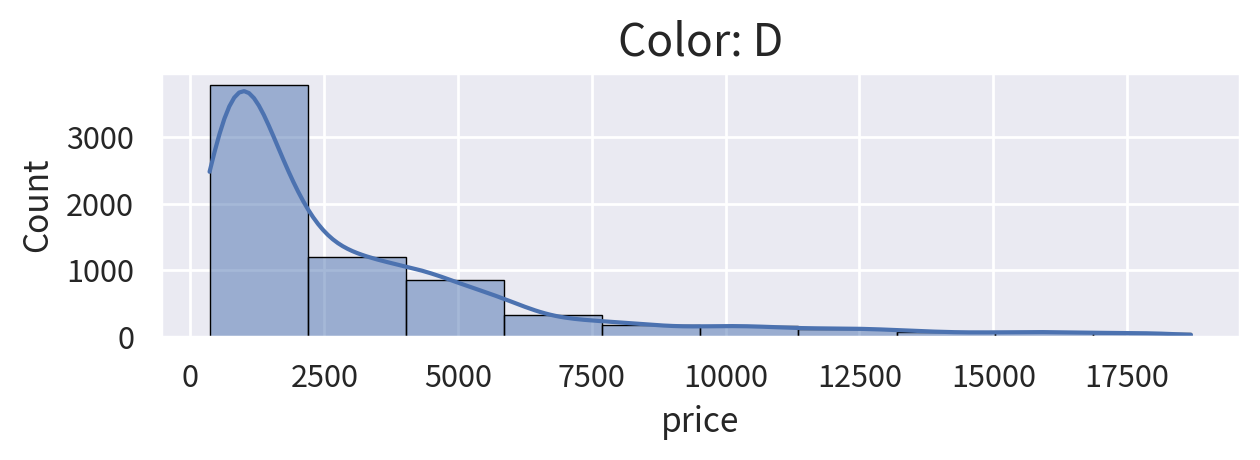

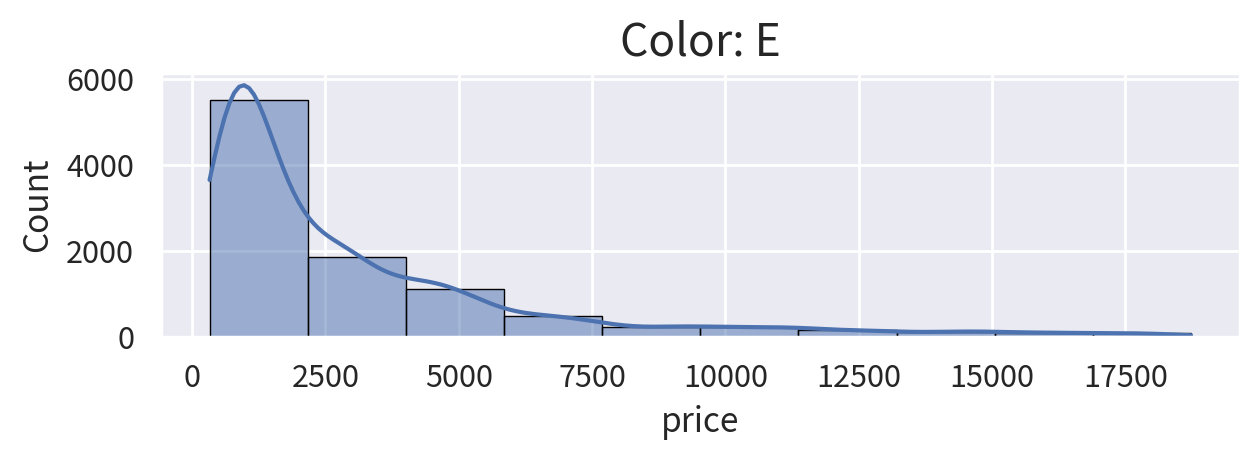

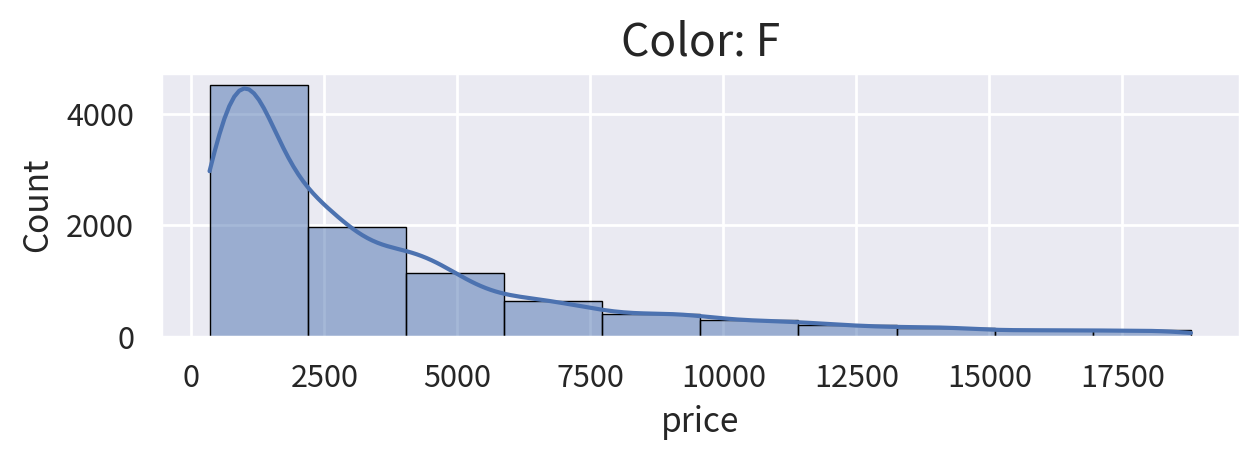

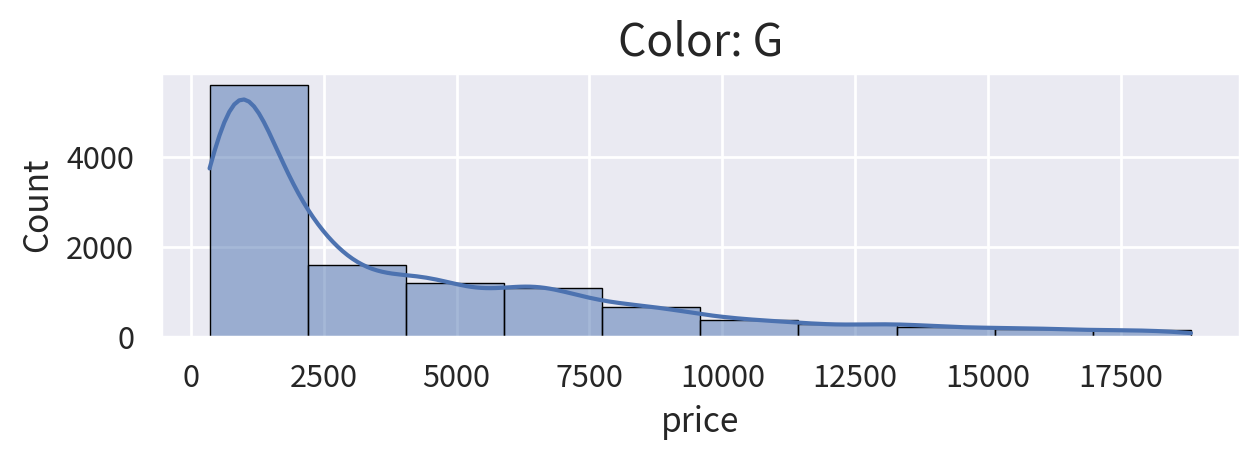

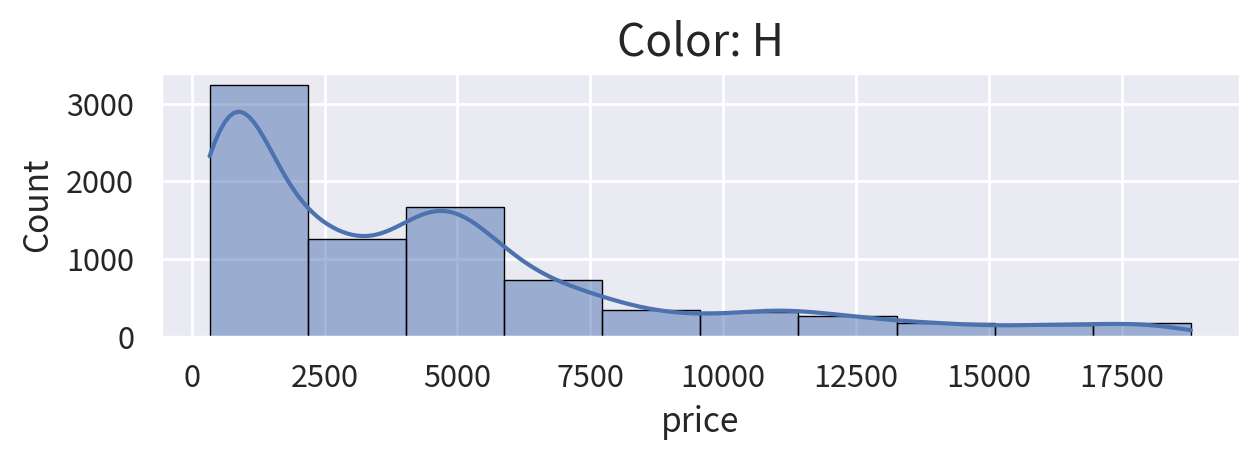

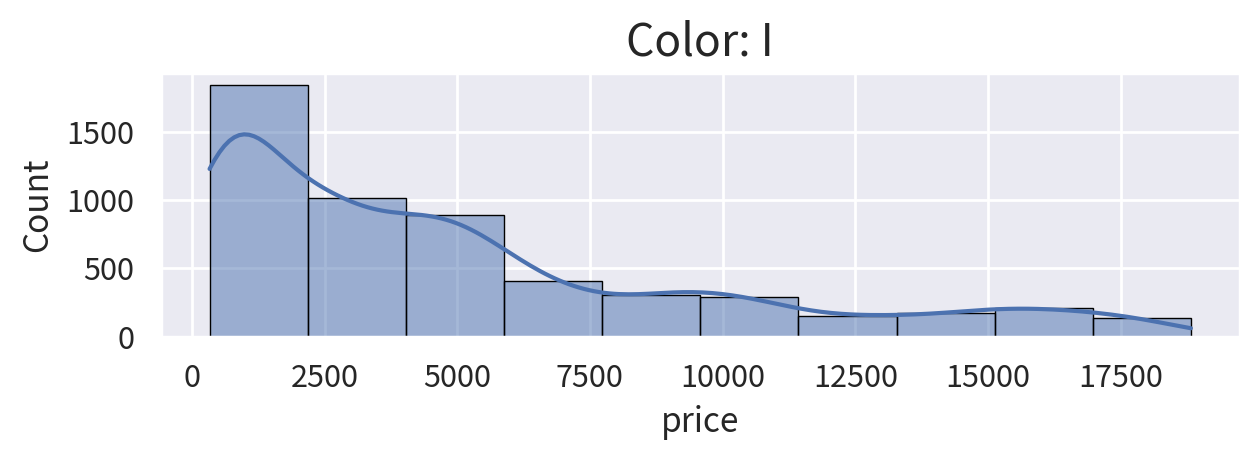

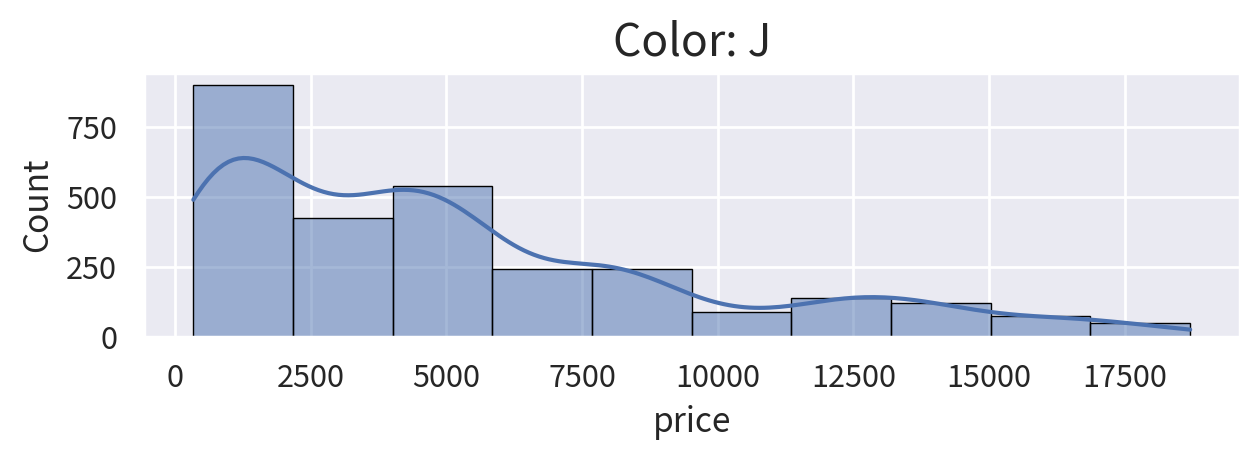

In [122]:
color_values=sorted(list(df['color'].unique()))
print(color_values)

for m in color_values:
    mdf = df.query("color == @m")
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
    width_px = 1280             #그래프 가로 크기
    height_px = 480             #그래프 세로 크기
    rows = 1                    #도화지의 행 수
    cols = 1                    #도화지의 열 수
    figsize = (width_px / my_dpi, height_px / my_dpi)
    fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

    # 2) barplot 그리기
    sb.histplot(
        data=mdf,
        x="price",
        bins=10,
        edgecolor='black',
        linewidth=0.5,
        kde=True
    )

    # 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
    ax.set_title(f"Color: {m}", fontsize=16)
    ax.grid(True)

    # 4) 출력
    plt.tight_layout()                      #여백 제거
    # plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
    plt.show()                              #그래프 화면 출력
    plt.close()                             #그래프 작업 종료

['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2']


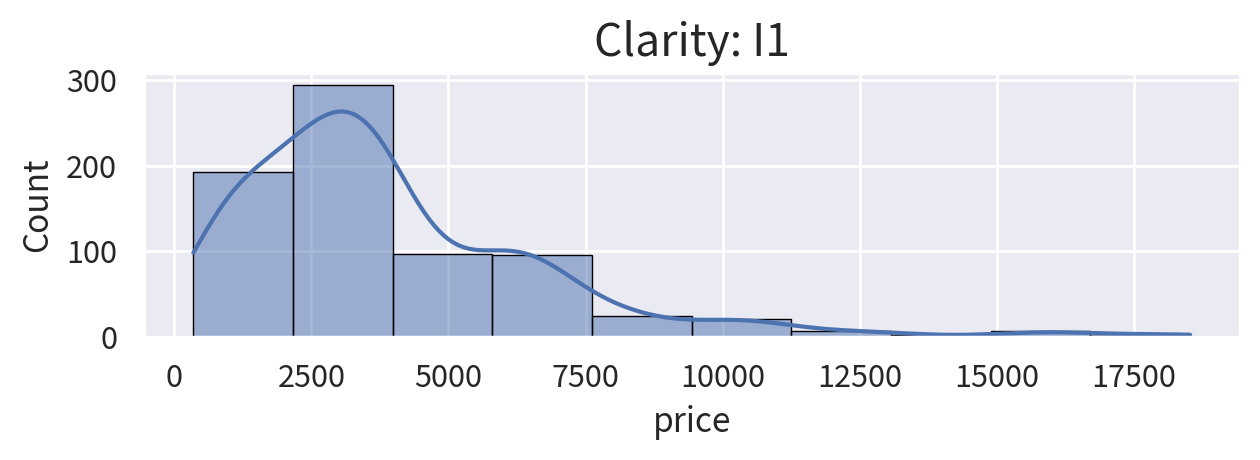

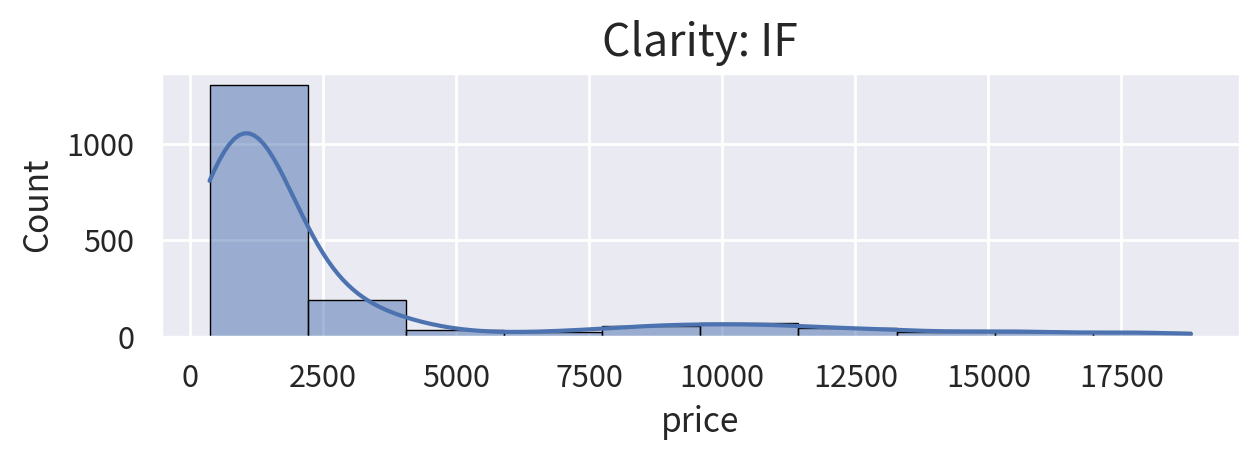

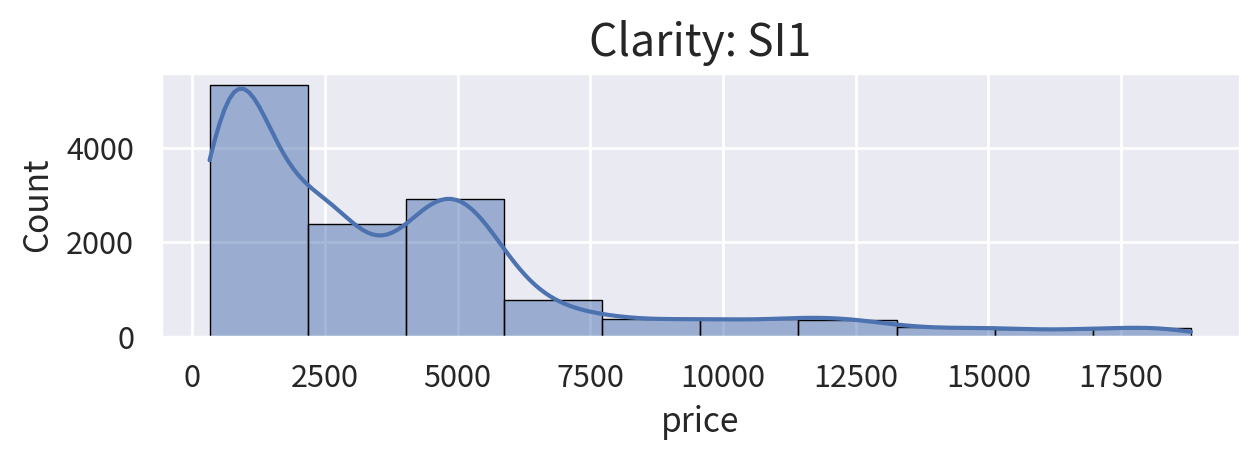

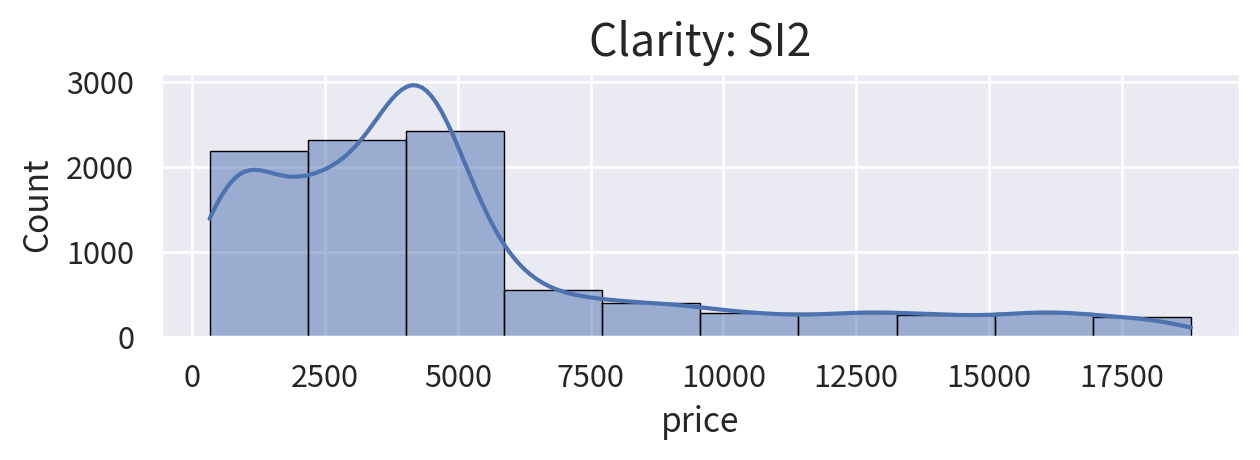

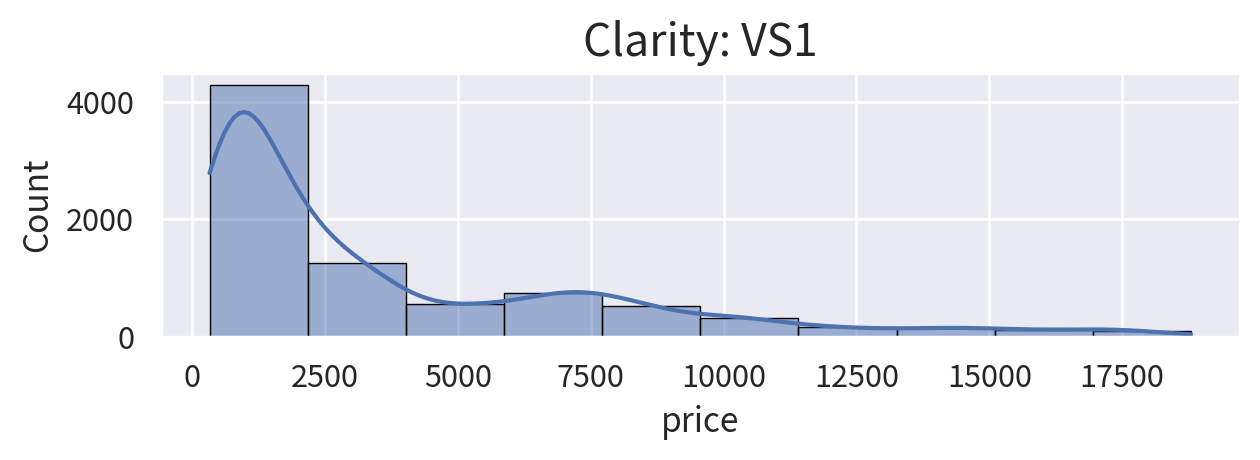

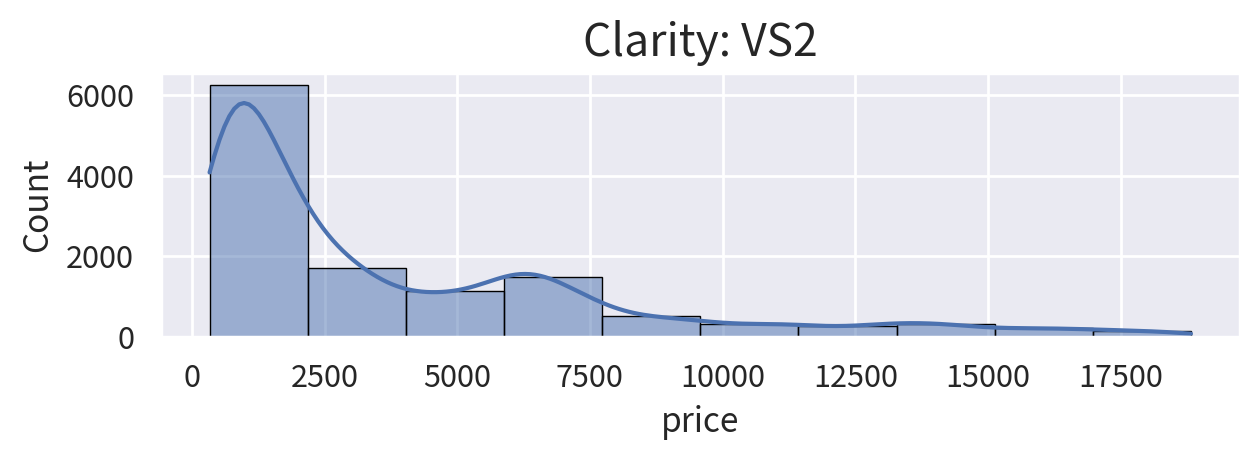

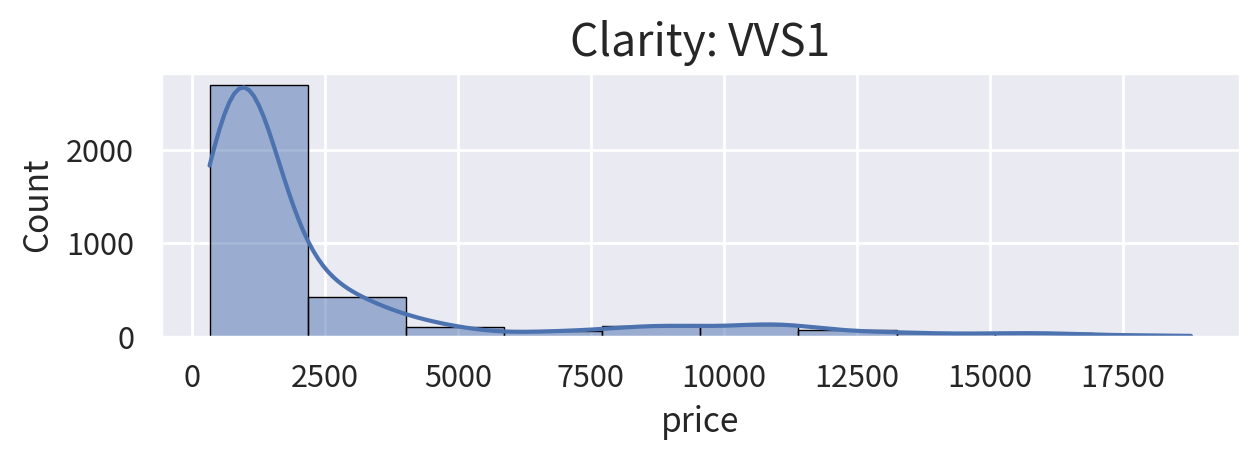

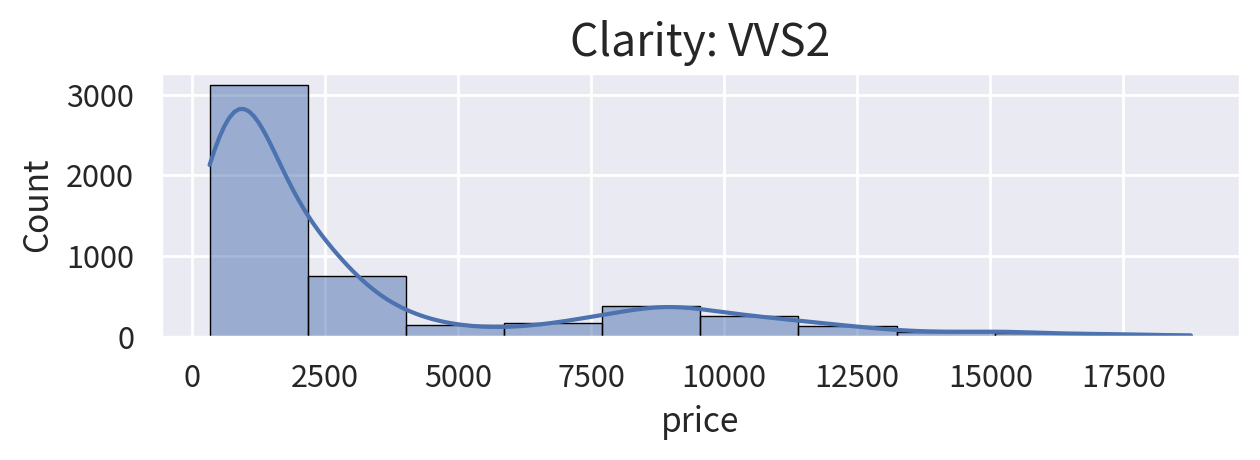

In [123]:
clarity_values=sorted(list(df['clarity'].unique()))
print(clarity_values)

for m in clarity_values:
    mdf = df.query("clarity == @m")
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
    width_px = 1280             #그래프 가로 크기
    height_px = 480             #그래프 세로 크기
    rows = 1                    #도화지의 행 수
    cols = 1                    #도화지의 열 수
    figsize = (width_px / my_dpi, height_px / my_dpi)
    fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

    # 2) barplot 그리기
    sb.histplot(
        data=mdf,
        x="price",
        bins=10,
        edgecolor='black',
        linewidth=0.5,
        kde=True
    )

    # 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
    ax.set_title(f"Clarity: {m}", fontsize=16)
    ax.grid(True)

    # 4) 출력
    plt.tight_layout()                      #여백 제거
    # plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
    plt.show()                              #그래프 화면 출력
    plt.close()                             #그래프 작업 종료

- 중앙값, 분산, 분포의 겹침 정도를 관찰하며 다음 질문에 답해보자.
    - 어떤 품질 변수는 가격 차이가 뚜렷한가?
    - 어떤 경우에는 등급이 달라도 가격이 크게 겹치는가?
- 숫자보다 패턴과 느낌을 중심으로 정리해보자.
---
- 가격차이가 뚜렷한 변수 = Clarity (투명도) 
- Cut과 Color의 분포가 크게 겹치는 것을 보아하니 Cut과 Color 둘 다 고만고만하면 가격이 겹치는 듯..?
    - 투명도가 핵심인 것 같음.

#### 미션 5. "Premium 컷은 정말 더 비쌀까?"
> Premium 컷 다이아몬드는 Ideal 컷보다 평균 가격이 높을까?
- 귀무가설 : Premium 컷 다이아몬드는 Ideal 컷보다 평균 가격이 높지 않다.
- 대립가설 : Premium 컷 다이아몬드는 Ideal 컷보다 평균 가격이 높다.

In [124]:
gdf = df.filter(['cut','price']).groupby(['cut'], as_index=False).mean()
gdf

C:\Users\itwill\AppData\Local\Temp\ipykernel_8804\1426818070.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gdf = df.filter(['cut','price']).groupby(['cut'], as_index=False).mean()


,cut,price
0,Fair,4358.757764
1,Good,3928.864452
2,Ideal,3457.541970
3,Premium,4584.257704
4,Very Good,3981.759891


cut      quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- 등급별 평균 가격을 확인해보면 Ideal이 제일 낮은 것을 알 수 있음. Premium이 제일 높고 그 다음은 Fair, Very Good, Good, Ideal 순서
- 그럼 평균대로라면 귀무가설이 채택 되어야 하는데.. 유의한가?
---
- 확인하기 위해 ideal 별 가격과 premium 별 가격이 있는 데이터프레임 생성

In [138]:
import pandas as pd
from pandas import melt
# ideal, premium 별 가격 데이터프레임 생성
df5 = df[df['cut'].isin(['Ideal', 'Premium'])][['cut','price']]
df5

,cut,price
0,Ideal,326
1,Premium,326
3,Premium,334
11,Ideal,340
12,Premium,342
...,...,...
53931,Premium,2756
53934,Premium,2757
53935,Ideal,2757
53938,Premium,2757


In [146]:
from pandas import pivot_table
from scipy.stats import t, normaltest, bartlett, levene
df6 = df5.copy()
df6['idx'] = df.groupby('cut').cumcount()
df7 = pivot_table(df6, index='idx', columns='cut', values='price')
df7

C:\Users\itwill\AppData\Local\Temp\ipykernel_8804\3884987638.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df6['idx'] = df.groupby('cut').cumcount()
C:\Users\itwill\AppData\Local\Temp\ipykernel_8804\3884987638.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df7 = pivot_table(df6, index='idx', columns='cut', values='price')


cut,Ideal,Premium
idx,,
0,326.0,326.0
1,340.0,334.0
2,344.0,342.0
3,348.0,345.0
4,403.0,345.0
...,...,...
21546,2756.0,NaN
21547,2756.0,NaN
21548,2756.0,NaN


In [ ]:
#정규성, 등분산성 검정
equal_var_fields = []
normal_dist = True
report = []
values = []

for c in df7.columns:
    target = df7[c].dropna()
    values.append(target)

    s,p = normaltest(target)
    normalize = p>0.05
    report.append({
        'field': c,
        'statistic': s,
        'p-value': p,
        'result': normalize
    })

In [140]:
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

lm = ols('price ~ C(cut)', data=df5).fit()
anova_result = anova_lm(lm)
anova_result

,df,sum_sq,mean_sq,F,PR(>F)
C(cut),4.0,1.073120e+10,2.682801e+09,165.335725,1.702654e-140
Residual,35339.0,5.734242e+11,1.622639e+07,NaN,NaN


In [141]:
s = anova_result['F'].iloc[0]
p = anova_result['PR(>F)'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p<=0.05 else "귀무")

'statistic: 165.336, p-value: 0.000, 대립가설 채택'

In [143]:
#사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_gameshowell, pairwise_tests

tukey = pairwise_tukeyhsd(df['price'], df['cut'])
tukey_table = tukey.summary()
tukey_df = DataFrame(tukey_table.data[1:],columns=tukey_table.data[0])
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Fair,Good,-429.8933,0.0015,-740.4593,-119.3273,True
1,Fair,Ideal,-901.2158,0.0000,-1180.5808,-621.8507,True
2,Fair,Premium,225.4999,0.1951,-59.2763,510.2762,False
3,Fair,Very Good,-376.9979,0.0031,-663.8719,-90.1239,True
4,Good,Ideal,-471.3225,0.0000,-642.3685,-300.2765,True
5,Good,Premium,655.3933,0.0000,475.6451,835.1414,True
6,Good,Very Good,52.8954,0.9341,-130.1581,235.9489,False
7,Ideal,Premium,1126.7157,0.0000,1008.8048,1244.6267,True
8,Ideal,Very Good,524.2179,0.0000,401.3270,647.1088,True
9,Premium,Very Good,-602.4978,0.0000,-737.2377,-467.7579,True
